In [1]:
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
from astropy.io import fits
import pandas as pd
import numpy as np
import warnings
import glob
import sys
import os

warnings.filterwarnings('ignore')

In [2]:
os.chdir('/home/fgran/iSpec/')
import ispec
sys.path.append('/home/fgran/iSpec/')

In [3]:
#Move to the correct directory: Pristine-UVES
os.chdir('/store/teams/cosmos/fgran/data/Pristine-UVES/')

In [4]:
os.environ['NUMEXPR_MAX_THREADS'] = '80' #change this number using the correct number of cores/threads in jupyter.slurm

In [5]:
#Define continuum regions from AMBRE spectra of similar properties
#SKIP THIS PART IF THE CONTINUUM REGIONS ALREADY EXISTS

In [6]:
ambre = ispec.read_spectrum('AMBRE/s4750:g+2.0:m1.0:t02:z-2.50:a+0.40.AMBRE')

In [7]:
# ambre['waveobs'] = ambre['waveobs']/10.
# blue_wfilter = ispec.create_wavelength_filter(ambre, wave_base=370.0, wave_top=450.0)
# blue2_wfilter = ispec.create_wavelength_filter(ambre, wave_base=330.0, wave_top=390.0)
# red1_wfilter = ispec.create_wavelength_filter(ambre, wave_base=473.0, wave_top=570.0)
# red2_wfilter = ispec.create_wavelength_filter(ambre, wave_base=585.0, wave_top=680.0)

# ambre_blue = ambre[blue_wfilter]
# ambre_blue2 = ambre[blue2_wfilter]
# ambre_red1 = ambre[red1_wfilter]
# ambre_red2 = ambre[red2_wfilter]

In [8]:
# #Fit a line to the ambre synthetics
# model = 'Polynomy'
# degree = 1
# nknots = None

# # Strategy: Filter first median values and secondly MAXIMUMs in order to find the continuum
# order = 'median+max'
# median_wave_range = 0.5
# max_wave_range = 1.0

# #AMBRE properties
# ambre_resolution = 120000
# sigma = 0.01
# fixed_wave_step = 0.1

In [9]:
# star_continuum_model_blue = ispec.fit_continuum(ambre_blue, nknots=nknots, degree=degree, median_wave_range=median_wave_range, 
#                                                 max_wave_range=max_wave_range, model=model, order=order, automatic_strong_line_detection=True, 
#                                                 strong_line_probability=0.95, use_errors_for_fitting=True)
# star_continuum_model_blue2 = ispec.fit_continuum(ambre_blue2, nknots=nknots, degree=degree, median_wave_range=median_wave_range, 
#                                                 max_wave_range=max_wave_range, model=model, order=order, automatic_strong_line_detection=True, 
#                                                 strong_line_probability=0.95, use_errors_for_fitting=True)
# star_continuum_model_red1 = ispec.fit_continuum(ambre_red1, nknots=nknots, degree=degree, median_wave_range=median_wave_range, 
#                                                 max_wave_range=max_wave_range, model=model, order=order, automatic_strong_line_detection=True, 
#                                                 strong_line_probability=0.95, use_errors_for_fitting=True)
# star_continuum_model_red2 = ispec.fit_continuum(ambre_red2, nknots=nknots, degree=degree, median_wave_range=median_wave_range, 
#                                                 max_wave_range=max_wave_range, model=model, order=order, automatic_strong_line_detection=True, 
#                                                 strong_line_probability=0.95, use_errors_for_fitting=True)

In [10]:
# max_continuum_diff = 0.02
# continuum_regions_blue2 = ispec.find_continuum(ambre_blue2, resolution = ambre_resolution, max_std_continuum = sigma, 
#                                          continuum_model = star_continuum_model_blue2, max_continuum_diff = max_continuum_diff)
# max_continuum_diff = 0.015
# continuum_regions_blue = ispec.find_continuum(ambre_blue, resolution = ambre_resolution, max_std_continuum = sigma, 
#                                          continuum_model = star_continuum_model_blue, max_continuum_diff = max_continuum_diff)
# continuum_regions_red1 = ispec.find_continuum(ambre_red1, resolution = ambre_resolution, max_std_continuum = sigma, 
#                                          continuum_model = star_continuum_model_red1, max_continuum_diff = max_continuum_diff)
# max_continuum_diff = 0.03
# continuum_regions_red2 = ispec.find_continuum(ambre_red2, resolution = ambre_resolution, max_std_continuum = sigma, 
#                                          continuum_model = star_continuum_model_red2, max_continuum_diff = max_continuum_diff)

In [11]:
# ispec.write_continuum_regions(continuum_regions_blue, 'continuum_model/continuum_regions_blue.txt')
# ispec.write_continuum_regions(continuum_regions_blue2, 'continuum_model/continuum_regions_blue2.txt')
# ispec.write_continuum_regions(continuum_regions_red1, 'continuum_model/continuum_regions_red1.txt')
# ispec.write_continuum_regions(continuum_regions_red2, 'continuum_model/continuum_regions_red2.txt')

In [12]:
# del model, degree, nknots, order, median_wave_range, max_wave_range, ambre_resolution, sigma, fixed_wave_step
# del blue_wfilter, red1_wfilter, red2_wfilter, ambre_blue, ambre_red1, ambre_red2, ambre
# del star_continuum_model_blue, star_continuum_model_blue2, star_continuum_model_red1, star_continuum_model_red2
# del continuum_regions_blue, continuum_regions_blue2, continuum_regions_red1, continuum_regions_red2, max_continuum_diff

In [13]:
#Iterate over blue and red to normalise and derive RVs
#CONTINUE WITH THIS PART IF AMBRE CONTINUUM REGIONS ALREADY EXISTS

In [14]:
continuum_regions_blue = ispec.read_continuum_regions('continuum_model/continuum_regions_blue.txt')
continuum_regions_blue2 = ispec.read_continuum_regions('continuum_model/continuum_regions_blue2.txt')
continuum_regions_red1 = ispec.read_continuum_regions('continuum_model/continuum_regions_red1.txt')
continuum_regions_red2 = ispec.read_continuum_regions('continuum_model/continuum_regions_red2.txt')

In [15]:
rv_template_blue = ispec.read_spectrum('rv_templates/rv_blue.csv')
rv_template_blue['waveobs'] = rv_template_blue['waveobs']/10.
rv_template_red1 = ispec.read_spectrum('rv_templates/rv_red1.csv')
rv_template_red1['waveobs'] = rv_template_red1['waveobs']/10.
rv_template_red2 = ispec.read_spectrum('rv_templates/rv_red2.csv')
rv_template_red2['waveobs'] = rv_template_red2['waveobs']/10.

In [16]:
#Original UVES nominal delta lambda = 0.0014 nm
delta_wave_resample = 2.0 * 0.0014
ini_wl_resample_blue = 370.0 #nm
end_wl_resample_blue = 450.0 #nm
ini_wl_resample_blue2 = 330.0 #nm
end_wl_resample_blue2 = 390.0 #nm
ini_wl_resample_red1 = 473.0 #nm
end_wl_resample_red1 = 570.0 #nm
ini_wl_resample_red2 = 585.0 #nm
end_wl_resample_red2 = 680.0 #nm

#Nominal UVES resolving power = 42000
model = 'Splines'#'Splines' # "Polynomy"
degree = 5
nknots = None # Automatic: 1 spline every 5 nm

# Strategy: Filter first median values and secondly MAXIMUMs in order to find the continuum
order = 'median+max'
median_wave_range = 0.01
max_wave_range = 0.011

columns = ['source_id', 'spec_id','run', 'blue_file', 'red_file', 'airmass', 'seeing', 'mjd', 'OB', 'exptime', 'ra', 'dec', 
           'blue_snr', 'red_snr', 'nom_res_blue', 'nom_res_red', 'barycor'] #, 'rv_blue', 'erv_blue', 'rv_red1', 'erv_red1', 'rv_red2', 'erv_red2']

resample_wl_blue = np.arange(ini_wl_resample_blue, end_wl_resample_blue, delta_wave_resample)
resample_wl_blue2 = np.arange(ini_wl_resample_blue2, end_wl_resample_blue2, delta_wave_resample)
resample_wl_red1 = np.arange(ini_wl_resample_red1, end_wl_resample_red1, delta_wave_resample)
resample_wl_red2 = np.arange(ini_wl_resample_red2, end_wl_resample_red2, delta_wave_resample)

In [17]:
speclist = sorted(glob.glob('11*/*.fits'))

In [18]:
blue_list = [spectra for spectra in speclist if fits.open(spectra)[0].header['HIERARCH ESO INS PATH'] == 'BLUE']
red_list = [spectra for spectra in speclist if fits.open(spectra)[0].header['HIERARCH ESO INS PATH'] == 'RED']

In [19]:
data_to_write = np.empty((len(blue_list), len(columns))).astype(object)

In [20]:
%%time

for i, blue_file in enumerate(blue_list):
    
    b_header = fits.open(blue_file)[0].header
    
    for j, red_file in enumerate(red_list):
        
        r_header = fits.open(red_file)[0].header
        if b_header['OBJECT'] == r_header['OBJECT']:
            
            try:
                
                barycor = b_header['HIERARCH ESO QC VRAD BARYCOR']
                
                source_id = b_header['OBJECT'].split(' ')[2]
                run = b_header['PROG_ID']
                airmass = b_header['HIERARCH ESO TEL AIRM START']
                seeing = b_header['HIERARCH ESO TEL IA FWHM']

                mjd = b_header['MJD-OBS']
                OB = b_header['OBID1']
                exptime = b_header['EXPTIME']

                ra = b_header['RA']
                dec = b_header['DEC']

                blue_snr = b_header['SNR']
                red_snr = r_header['SNR']

                nominal_resolution_blue = b_header['SPEC_RES']
                nominal_resolution_red = r_header['SPEC_RES']
                
                spec_id = '%s_%d_%03d' %(source_id, OB, i)

                data_to_write[i, :] = np.asarray([source_id, spec_id, run, blue_file.split('/')[1], red_file.split('/')[1], airmass, seeing, mjd, OB, exptime, ra, dec, blue_snr, red_snr, 
                                                nominal_resolution_blue, nominal_resolution_red, barycor])
                
                break
            except:
                
                barycor = 0.0
                
                source_id = b_header['OBJECT'].split(' ')[2]
                run = b_header['PROG_ID']
                airmass = b_header['HIERARCH ESO TEL AIRM START']
                seeing = b_header['HIERARCH ESO TEL IA FWHM']

                mjd = b_header['MJD-OBS']
                OB = b_header['OBID1']
                exptime = b_header['EXPTIME']

                ra = b_header['RA']
                dec = b_header['DEC']

                blue_snr = b_header['SNR']
                red_snr = r_header['SNR']

                nominal_resolution_blue = b_header['SPEC_RES']
                nominal_resolution_red = r_header['SPEC_RES']
                
                spec_id = '%s_%d_%03d' %(source_id, OB, i)

                data_to_write[i, :] = np.asarray([source_id, spec_id, run, blue_file.split('/')[1], red_file.split('/')[1], airmass, seeing, mjd, OB, exptime, ra, dec, blue_snr, red_snr, 
                                                nominal_resolution_blue, nominal_resolution_red, barycor])        
        else:
            continue

CPU times: user 1min 25s, sys: 8.8 s, total: 1min 34s
Wall time: 1min 34s


In [21]:
uves = pd.DataFrame(data=data_to_write, columns=columns)

In [22]:
uves.query("barycor == '0.0'")

,source_id,spec_id,run,blue_file,red_file,airmass,seeing,mjd,OB,exptime,ra,dec,blue_snr,red_snr,nom_res_blue,nom_res_red,barycor
125,4905666294932720000,4905666294932720000_3708505_125,112.25XW.001,ADP.2024-03-09T05:54:26.306.fits,ADP.2024-03-09T05:54:26.296.fits,1.248,1.01,60201.163159851,3708505,4799.9993,1.873403,-60.7962,72.8889540024326,132.542619149351,36840.0,34540.0,0.0
157,3608416056475856512,3608416056475856512_3708499_157,112.25XW.001,ADP.2024-03-12T09:18:01.956.fits,ADP.2024-03-12T09:18:01.946.fits,1.23,1.2,60359.214985687,3708499,4800.0022,201.66028,-13.86002,73.1693018088233,135.818191057341,36840.0,34540.0,0.0
158,3725429210639578752,3725429210639578752_3708502_158,112.25XW.001,ADP.2024-03-12T09:18:01.974.fits,ADP.2024-03-12T09:18:01.964.fits,1.286,1.12,60359.274210561,3708502,4799.9957,206.132034,9.69661,60.8966393277221,118.625821960174,36840.0,34540.0,0.0


In [23]:
uves = uves[np.asarray(uves.mjd.values).astype(float) > 1]

In [24]:
uves.reset_index(inplace=True)

In [25]:
columns = ['source_id', 'spec_id','run', 'blue_file', 'red_file', 'airmass', 'seeing', 'mjd', 'OB', 'exptime', 'ra', 'dec', 
           'blue_snr', 'red_snr', 'nom_res_blue', 'nom_res_red', 'barycor', 'rv_blue2', 'erv_blue2', 'rv_blue', 'erv_blue', 'rv_red1', 'erv_red1', 'rv_red2', 'erv_red2']

In [27]:
#Define main function to normalise and measure RVs

In [34]:
def norm_RV_parallel_binaries(i, input_row):
    
    spec = ispec.read_spectrum('%s/%s' %(input_row.run, input_row.red_file))
    spec['waveobs'] = spec['waveobs']/10.
    spec = spec[ispec.create_wavelength_filter(spec, wave_base=ini_wl_resample_red1, wave_top=end_wl_resample_red1)]
    spec['flux'] = spec['flux'] / np.median(spec['flux'])

    #Calculate RVs
    models, ccf = ispec.cross_correlate_with_template(spec, rv_template_red1, lower_velocity_limit=-500, upper_velocity_limit=500, velocity_step=0.1, fourier=False)

    if len(models) == 1:
        rv_1 = np.round(models[0].mu(), 3) # km/s
        erv_1 = np.round(models[0].emu(), 3) # km/s
        rv_2 = 0.0 # km/s
        erv_2 = 0.0 # km/s

    else:
        rv_1 = np.round(models[0].mu(), 3) # km/s
        erv_1 = np.round(models[0].emu(), 3) # km/s
        rv_2 = np.round(models[1].mu(), 3) # km/s
        erv_2 = np.round(models[1].emu(), 3) # km/s

    ccf_columns = ['x', 'y']
    ccf_to_write = np.vstack((ccf.x, ccf.y)).T
    pd.DataFrame(data = ccf_to_write, columns=ccf_columns).to_csv('rv_ccf/ccf_%s.csv' %input_row.spec_id, index=False, header=True)

    columns = ['source_id', 'spec_id', 'run', 'blue_file', 'red_file', 'barycor', 'rv_1', 'erv_1', 'rv_2', 'erv_2', 'n_models']
    data_to_write = np.vstack((input_row.source_id, input_row.spec_id, input_row.run, input_row.blue_file, input_row.red_file,
                               input_row.barycor, rv_1, erv_1, rv_2, erv_2, len(models))).T
    pd.DataFrame(data = data_to_write, columns=columns).to_csv('rv_ccf/uves_ccf_models.csv', index=False, header=False, mode='a')
    del ccf_to_write, data_to_write, models, ccf


    return

In [35]:
def norm_RV_parallel(i, input_row):
    
    # if i != 0:
    #     return

    ####################################################################################################################################################################################
    #BLUE2 PART
    # if os.path.exists('norm_RV_corr/%s/blue2_%s' %(input_row.run, input_row.blue_file)):
    #     return
    # else:
        spec = ispec.read_spectrum('%s/%s' %(input_row.run, input_row.blue_file))
        spec['waveobs'] = spec['waveobs']/10.
        spec = spec[ispec.create_wavelength_filter(spec, wave_base=ini_wl_resample_blue2, wave_top=end_wl_resample_blue2)]
        spec['flux'] = spec['flux'] / np.median(spec['flux'])

        #Calculate RVs
        models, ccf = ispec.cross_correlate_with_template(spec, rv_template_blue, lower_velocity_limit=-500, upper_velocity_limit=500, velocity_step=0.1, fourier=False)
        rv_blue2 = np.round(models[0].mu(), 3) # km/s
        erv_blue2 = np.round(models[0].emu(), 3) # km/s
        spec = ispec.correct_velocity(spec, rv_blue2)

        del models, ccf

        #Resample and normalise spec
        nknots = None
        median_wave_range = 0.005
        max_wave_range = 0.2
        spec = ispec.resample_spectrum(spec, resample_wl_blue2, method='bessel', zero_edges=False)
        star_continuum_model = ispec.fit_continuum(spec, continuum_regions=continuum_regions_blue2, nknots=nknots, degree=degree, 
                                               median_wave_range=median_wave_range, max_wave_range=max_wave_range, model=model, order=order, 
                                               automatic_strong_line_detection=True, strong_line_probability=0.95, use_errors_for_fitting=True)
        spec = ispec.normalize_spectrum(spec, star_continuum_model, consider_continuum_errors=True)

        del star_continuum_model

        #Save normalised spectrum
        ispec.write_spectrum(spec, 'norm_RV_corr/%s/blue2_%s' %(input_row.run, input_row.blue_file))
    
    ####################################################################################################################################################################################
    
    ####################################################################################################################################################################################
    #BLUE PART
    # if os.path.exists('norm_RV_corr/%s/blue_%s' %(input_row.run, input_row.blue_file)):
    #     return
    # else:
        spec = ispec.read_spectrum('%s/%s' %(input_row.run, input_row.blue_file))
        spec['waveobs'] = spec['waveobs']/10.
        spec = spec[ispec.create_wavelength_filter(spec, wave_base=ini_wl_resample_blue, wave_top=end_wl_resample_blue)]
        spec['flux'] = spec['flux'] / np.median(spec['flux'])

        #Calculate RVs
        models, ccf = ispec.cross_correlate_with_template(spec, rv_template_blue, lower_velocity_limit=-500, upper_velocity_limit=500, velocity_step=0.1, fourier=False)
        rv_blue = np.round(models[0].mu(), 3) # km/s
        erv_blue = np.round(models[0].emu(), 3) # km/s
        spec = ispec.correct_velocity(spec, rv_blue)

        del models, ccf

        #Resample and normalise spec
        nknots = 50
        median_wave_range = 0.01
        max_wave_range = 0.011
        spec = ispec.resample_spectrum(spec, resample_wl_blue, method='bessel', zero_edges=False)
        star_continuum_model = ispec.fit_continuum(spec, continuum_regions=continuum_regions_blue, nknots=nknots, degree=degree, 
                                               median_wave_range=median_wave_range, max_wave_range=max_wave_range, model=model, order=order, 
                                               automatic_strong_line_detection=True, strong_line_probability=0.55, use_errors_for_fitting=True)
        spec = ispec.normalize_spectrum(spec, star_continuum_model, consider_continuum_errors=True)

        del star_continuum_model

        #Save normalised spectrum
        ispec.write_spectrum(spec, 'norm_RV_corr/%s/blue_%s' %(input_row.run, input_row.blue_file))
    
    ####################################################################################################################################################################################
    #RED1 PART
    # if os.path.exists('norm_RV_corr/%s/red1_%s' %(input_row.run, input_row.red_file)):
    #     return
    # else:
        spec = ispec.read_spectrum('%s/%s' %(input_row.run, input_row.red_file))
        spec['waveobs'] = spec['waveobs']/10.
        spec = spec[ispec.create_wavelength_filter(spec, wave_base=ini_wl_resample_red1, wave_top=end_wl_resample_red1)]
        spec['flux'] = spec['flux'] / np.median(spec['flux'])

        #Calculate RVs
        models, ccf = ispec.cross_correlate_with_template(spec, rv_template_red1, lower_velocity_limit=-500, upper_velocity_limit=500, velocity_step=0.1, fourier=False)
        rv_red1 = np.round(models[0].mu(), 3) # km/s
        erv_red1 = np.round(models[0].emu(), 3) # km/s
        spec = ispec.correct_velocity(spec, rv_red1)

        del models, ccf

        #Resample and normalise spec
        nknots = 50
        median_wave_range = 0.01
        max_wave_range = 0.011
        spec = ispec.resample_spectrum(spec, resample_wl_red1, method='bessel', zero_edges=False)
        star_continuum_model = ispec.fit_continuum(spec, continuum_regions=continuum_regions_red1, nknots=nknots, degree=degree, 
                                               median_wave_range=median_wave_range, max_wave_range=max_wave_range, model=model, order=order, 
                                               automatic_strong_line_detection=True, strong_line_probability=0.55, use_errors_for_fitting=True)
        spec = ispec.normalize_spectrum(spec, star_continuum_model, consider_continuum_errors=True)

        del star_continuum_model

        #Save normalised spectrum
        ispec.write_spectrum(spec, 'norm_RV_corr/%s/red1_%s' %(input_row.run, input_row.red_file))

    ####################################################################################################################################################################################    
    #RED2 PART
    # if os.path.exists('norm_RV_corr/%s/red2_%s' %(input_row.run, input_row.red_file)):
    #     return
    # else:
        spec = ispec.read_spectrum('%s/%s' %(input_row.run, input_row.red_file))
        spec['waveobs'] = spec['waveobs']/10.
        spec = spec[ispec.create_wavelength_filter(spec, wave_base=ini_wl_resample_red2, wave_top=end_wl_resample_red2)]
        spec['flux'] = spec['flux'] / np.median(spec['flux'])

        #Calculate RVs
        models, ccf = ispec.cross_correlate_with_template(spec, rv_template_red2, lower_velocity_limit=-500, upper_velocity_limit=500, velocity_step=0.1, fourier=False)
        rv_red2 = np.round(models[0].mu(), 3) # km/s
        erv_red2 = np.round(models[0].emu(), 3) # km/s
        spec = ispec.correct_velocity(spec, rv_red2)

        del models, ccf

        #Resample and normalise spec
        nknots = 50
        median_wave_range = 0.01
        max_wave_range = 0.011
        spec = ispec.resample_spectrum(spec, resample_wl_red2, method='bessel', zero_edges=False)
        star_continuum_model = ispec.fit_continuum(spec, continuum_regions=continuum_regions_red2, nknots=nknots, degree=degree, 
                                               median_wave_range=median_wave_range, max_wave_range=max_wave_range, model=model, order=order, 
                                               automatic_strong_line_detection=True, strong_line_probability=0.55, use_errors_for_fitting=True)
        spec = ispec.normalize_spectrum(spec, star_continuum_model, consider_continuum_errors=True)

        del star_continuum_model

        #Save normalised spectrum
        ispec.write_spectrum(spec, 'norm_RV_corr/%s/red2_%s' %(input_row.run, input_row.red_file))

   ################################################################################################################################################################################

    #Save results in individual files
    # if os.path.exists('tmp_norm_RV/norm_RV_%s_%s_%s_%03d.csv' %(input_row.run, input_row.source_id, input_row.OB, i)):
    #     return
    # else:
    # ######COMMENTED SECTION
    #     data_to_write = np.vstack((input_row.source_id, input_row.spec_id, input_row.run, input_row.blue_file, input_row.red_file,
    #                                input_row.airmass, input_row.seeing, input_row.mjd, input_row.OB, input_row.exptime, 
    #                                input_row.ra, input_row.dec, input_row.blue_snr, input_row.red_snr,
    #                                input_row.nom_res_blue, input_row.nom_res_red, input_row.barycor,
    #                                rv_blue2, erv_blue2, rv_blue, erv_blue, rv_red1, erv_red1, rv_red2, erv_red2)).T
    #     # columns = ['source_id', 'spec_id','run', 'blue_file', 'red_file', 'airmass', 'seeing', 'mjd', 'OB', 'exptime', 'ra', 'dec', 
    #     #        'blue_snr', 'red_snr', 'nom_res_blue', 'nom_res_red', 'barycor', 'rv_blue', 'erv_blue', 'rv_red1', 'erv_red1', 'rv_red2', 'erv_red2']
    #     # del rv_blue, erv_blue, rv_red1, erv_red1, rv_red2, erv_red2

    #     pd.DataFrame(data = data_to_write, columns=columns).to_csv('tmp_norm_RV/norm_RV_%s_%s_%s_%03d.csv' %(input_row.run, input_row.source_id, input_row.OB, i), index=False, header=False)
    #     del data_to_write

        return

In [36]:
# data_to_df = np.vstack((sourceids, run, blue_file, red_file, airmass, seeing, blue_list_snr, red_list_snr, res, barycor)).T
# header = pd.DataFrame(data=data_to_df, columns=['source_id', 'run', 'blue_file', 'red_file', 'airmass', 'seeing', 'blue_snr', 'red_snr', 'nominal_res', 'barycor'])
# header.source_id = header.source_id.astype(np.int64)
# header.reset_index(drop=True, inplace=True)

In [37]:
# input_to_iterrows = #header#.query("run == '111.251N.002'")
# input_to_iterrows.reset_index(drop=True, inplace=True)

In [44]:
# %%time
# os.system('rm rv_ccf/uves_ccf_models.csv')
# Parallel(n_jobs=80, verbose=1)(delayed(norm_RV_parallel_binaries)(i, input_row) for i, input_row in uves.iterrows());

In [45]:
# columns = ['source_id', 'spec_id', 'run', 'blue_file', 'red_file', 'barycor', 'rv_1', 'erv_1', 'rv_2', 'erv_2', 'n_models']
# models = pd.read_csv('rv_ccf/uves_ccf_models.csv', names=columns)

In [34]:
%%time

# os.system('rm norm_RV_corr/*/*.fits')

Parallel(n_jobs=100, verbose=2)(delayed(norm_RV_parallel)(i, input_row) for i, input_row in uves.iterrows());

# os.system('cat tmp_norm_RV/norm_RV_* > tmp_merged/UVES_p111_p112_header_rv.csv');
# os.system('rm tmp/norm_RV_*')

[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.
[2025-02-14 23:56:30,788] [INFO] [lines:__cross_correlation_function_uniform_in_velocity:1994]: 0.00%
[2025-02-14 23:56:30,794] [INFO] [lines:__cross_correlation_function_uniform_in_velocity:1994]: 0.00%
[2025-02-14 23:56:30,816] [INFO] [lines:__cross_correlation_function_uniform_in_velocity:1994]: 0.00%
[2025-02-14 23:56:30,824] [INFO] [lines:__cross_correlation_function_uniform_in_velocity:1994]: 0.00%
[2025-02-14 23:56:30,831] [INFO] [lines:__cross_correlation_function_uniform_in_velocity:1994]: 0.00%
[2025-02-14 23:56:30,878] [INFO] [lines:__cross_correlation_function_uniform_in_velocity:1994]: 0.00%
[2025-02-14 23:56:30,879] [INFO] [lines:__cross_correlation_function_uniform_in_velocity:1994]: 0.00%
[2025-02-14 23:56:30,887] [INFO] [lines:__cross_correlation_function_uniform_in_velocity:1994]: 0.00%
[2025-02-14 23:56:30,889] [INFO] [lines:__cross_correlation_function_uniform_in_velocity:1994]: 0.00%
[20

CPU times: user 5.55 s, sys: 1.65 s, total: 7.21 s
Wall time: 28min 11s


[Parallel(n_jobs=100)]: Done 160 out of 160 | elapsed: 28.2min finished


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [52]:
# source_id,spec_id,run,blue_file,red_file,airmass,seeing,mjd,OB,exptime,ra,dec,blue_snr,red_snr,nom_res_blue,nom_res_red,barycor,rv_blue2, erv_blue2,rv_blue,erv_blue,rv_red1,erv_red1,rv_red2,erv_red2
# os.system('cat tmp_norm_RV/norm_RV* > tmp_merged/uves_p111_p112_header_rv.csv');

In [ ]:
#END OF NORM_RV PROCESSING

In [16]:
#Tellurics preparations
tell = ispec.read_spectrum('/home/fgran/iSpec/input/spectra/templates/Synth.Tellurics.350_1100nm/template.txt.gz')
tel_wl_min_rv, tel_wl_max_rv = 625., 635.
tel_wl_min, tel_wl_max = 629.1, 630.1
mg_wl_min, mg_wl_max = 516.8, 518.5
tell = tell[ispec.create_wavelength_filter(tell, wave_base=tel_wl_min_rv, wave_top=tel_wl_max_rv)]
fit = fitting.LMLSQFitter()

In [1344]:
def eff_res_by_tell(i, input_row):
    
    # if i > 5:
    #     return
    
    #Effective resolution: telluric analysis 
    spec = ispec.read_spectrum('norm_RV_corr/%s/red2_%s' %(input_row.run, input_row.red_file))
    spec = spec[ispec.create_wavelength_filter(spec, wave_base=tel_wl_min_rv, wave_top=tel_wl_max_rv)]
    models, ccf = ispec.cross_correlate_with_template(spec, tell, lower_velocity_limit=-450, upper_velocity_limit=450, velocity_step=0.1, fourier=False)
    spec = ispec.correct_velocity(spec, models[0].mu())
    spec = spec[ispec.create_wavelength_filter(spec, wave_base=tel_wl_min, wave_top=tel_wl_max)]
    
    del models, ccf
    
    wl, fl = spec['waveobs'], spec['flux']
    mean_wl = np.mean(wl)
    wl = wl - mean_wl
    
    del spec
        
    voigt = Voigt1D(amplitude_L=-0.15, x_0=-0.38, fwhm_G=0.01, fwhm_L=0.01) + Voigt1D(amplitude_L=-0.15, x_0=-0.30, fwhm_G=0.01, fwhm_L=0.01) + \
            Voigt1D(amplitude_L=-0.15, x_0=-0.08, fwhm_G=0.01, fwhm_L=0.01) + \
            Voigt1D(amplitude_L=-0.15, x_0=0.00, fwhm_G=0.01, fwhm_L=0.01) + Voigt1D(amplitude_L=-0.15,  x_0=0.25, fwhm_G=0.01, fwhm_L=0.01) + \
            Voigt1D(amplitude_L=-0.15,  x_0=0.32, fwhm_G=0.01, fwhm_L=0.01) + Const1D(amplitude=1.0)
    voigt.fwhm_G_0.bounds = (0.0001, 0.15)
    voigt.fwhm_G_1.bounds = (0.0001, 0.15)
    voigt.fwhm_G_2.bounds = (0.0001, 0.15)
    voigt.fwhm_G_3.bounds = (0.0001, 0.15)
    voigt.fwhm_G_4.bounds = (0.0001, 0.15)
    voigt.fwhm_G_5.bounds = (0.0001, 0.15)
    voigt.fwhm_L_0.bounds = (0.0001, 0.15)
    voigt.fwhm_L_1.bounds = (0.0001, 0.15)
    voigt.fwhm_L_2.bounds = (0.0001, 0.15)
    voigt.fwhm_L_3.bounds = (0.0001, 0.15)
    voigt.fwhm_L_4.bounds = (0.0001, 0.15)
    voigt.fwhm_L_5.bounds = (0.0001, 0.15)
    voigt.amplitude_L_0.bounds = (-0.4, 0.05)
    voigt.amplitude_L_1.bounds = (-0.4, 0.05)
    voigt.amplitude_L_2.bounds = (-0.4, 0.05)
    voigt.amplitude_L_3.bounds = (-0.4, 0.05)
    voigt.amplitude_L_4.bounds = (-0.4, 0.05)
    voigt.amplitude_L_5.bounds = (-0.4, 0.05)
    g = fit(voigt, x=wl, y=fl, maxiter=5000)
    
    ######################BORRAR
    # plt.figure(figsize=(10,4))
    # x = np.linspace(np.min(wl), np.max(wl), num=500)
    # plt.step(wl, fl)
    # plt.plot(x, g(x))
    # plt.show()
    ######################

    tel_mean_nm = np.array([g.x_0_0.value, g.x_0_1.value, g.x_0_2.value, g.x_0_3.value, g.x_0_4.value, g.x_0_5.value]) + mean_wl #nm
    tel_fwhm_nm = np.array([g.fwhm_L_0.value/2. + np.sqrt(0.25*g.fwhm_L_0**2. + g.fwhm_G_0**2.),
                            g.fwhm_L_1.value/2. + np.sqrt(0.25*g.fwhm_L_1**2. + g.fwhm_G_1**2.),
                            g.fwhm_L_2.value/2. + np.sqrt(0.25*g.fwhm_L_2**2. + g.fwhm_G_2**2.),
                            g.fwhm_L_3.value/2. + np.sqrt(0.25*g.fwhm_L_3**2. + g.fwhm_G_3**2.),
                            g.fwhm_L_4.value/2. + np.sqrt(0.25*g.fwhm_L_4**2. + g.fwhm_G_4**2.),
                            g.fwhm_L_5.value/2. + np.sqrt(0.25*g.fwhm_L_5**2. + g.fwhm_G_5**2.)]) #* gaussian_sigma_to_fwhm #nm
    tel_fwhm_kms = (c.value / (tel_mean_nm / tel_fwhm_nm)) / 1000.0 # km/s
        
    # del tel_mean_nm, tel_fwhm_nm, voigt, g, wl, fl
    
    mg_spec = ispec.read_spectrum('norm_RV_corr/%s/red1_%s' %(input_row.run, input_row.red_file))
    mg_spec = mg_spec[ispec.create_wavelength_filter(mg_spec, wave_base=mg_wl_min, wave_top=mg_wl_max)]
    wl, fl = mg_spec['waveobs'], mg_spec['flux']
    mean_wl = np.mean(wl)
    wl = wl - mean_wl
        
    del mg_spec
    
    voigt = Voigt1D(amplitude_L=-0.80, x_0=-0.750, fwhm_G=0.01, fwhm_L=0.01) + Voigt1D(amplitude_L=-0.80, x_0=-0.50, fwhm_G=0.01, fwhm_L=0.01) + \
        Voigt1D(amplitude_L=-0.80, x_0=-0.385, fwhm_G=0.01, fwhm_L=0.01) + \
        Voigt1D(amplitude_L=-0.60, x_0= 0.710, fwhm_G=0.01, fwhm_L=0.01) + Const1D(amplitude=1.)
    voigt.fwhm_G_0.bounds = (0.0001, 0.15)
    voigt.fwhm_G_1.bounds = (0.0001, 0.15)
    voigt.fwhm_G_2.bounds = (0.0001, 0.15)
    voigt.fwhm_G_3.bounds = (0.0001, 0.15)
    voigt.fwhm_L_0.bounds = (0.0001, 0.15)
    voigt.fwhm_L_1.bounds = (0.0001, 0.15)
    voigt.fwhm_L_2.bounds = (0.0001, 0.15)
    voigt.fwhm_L_3.bounds = (0.0001, 0.15)
    voigt.amplitude_L_0.bounds = (-5.0, -0.01)
    voigt.amplitude_L_1.bounds = (-5.0, -0.01)
    voigt.amplitude_L_2.bounds = (-5.0, -0.01)
    voigt.amplitude_L_3.bounds = (-5.0, -0.01)
    g = fit(voigt, x=wl, y=fl, maxiter=5000)
    
    ####################BORRAR
    # plt.figure(figsize=(10,4))
    # x = np.linspace(np.min(wl), np.max(wl), num=500)
    # plt.step(wl, fl)
    # plt.plot(x, g(x))
    # plt.show()
    ####################
    
    mg_mean_nm = np.array([g.x_0_0.value, g.x_0_1.value, g.x_0_2.value, g.x_0_3.value]) + mean_wl #nm
    mg_fwhm_nm = np.array([g.fwhm_L_0.value/2. + np.sqrt(0.25*g.fwhm_L_0**2. + g.fwhm_G_0**2.),
                           g.fwhm_L_1.value/2. + np.sqrt(0.25*g.fwhm_L_1**2. + g.fwhm_G_1**2.),
                           g.fwhm_L_2.value/2. + np.sqrt(0.25*g.fwhm_L_2**2. + g.fwhm_G_2**2.),
                           g.fwhm_L_3.value/2. + np.sqrt(0.25*g.fwhm_L_3**2. + g.fwhm_G_3**2.)]) #* gaussian_sigma_to_fwhm #nm
    mg_fwhm_kms = (c.value / (mg_mean_nm / mg_fwhm_nm)) / 1000.0 # km/s
    
    R = int(c.value/(1000.0*(np.mean(mg_fwhm_kms) - np.mean(tel_fwhm_kms))))
    
    # del mg_mean_nm, mg_fwhm_nm, voigt, g, wl, fl
    
    ####################################################################################################################################################################################
    
    #Save results appending to the individual norm_RV_corr files
    data_to_write = np.vstack((str(input_row.source_id), R, np.mean(tel_fwhm_nm), np.std(tel_fwhm_nm), np.mean(tel_fwhm_kms), np.std(tel_fwhm_kms), 
                               np.mean(mg_fwhm_nm), np.std(mg_fwhm_nm), np.mean(mg_fwhm_kms), np.std(mg_fwhm_kms))).T
    pd.DataFrame(data = data_to_write, columns=['source_id', 'eff_res', 'tel_fwhm_nm', 'tel_fwhm_nm_rms', 'tel_fwhm_kms', 'tel_fwhm_kms_rms', 
                                                'mg_fwhm_nm', 'mg_fwhm_nm_rms', 'mg_fwhm_kms', 'mg_fwhm_kms_rms']).to_csv('tmp/norm_RV_res_%s_%d_%03d.csv' %(input_row.run, input_row.source_id, i), index=False, header=False)
   # source_id,eff_res,tel_fwhm_nm,tel_fwhm_kms,tel_fwhm_nm_rms,mg_fwhm_nm,mg_fwhm_kms,mg_fwhm_kms_rms
    del data_to_write
    
    return

In [1345]:
%%time

Parallel(n_jobs=-1, verbose=0)(delayed(eff_res_by_tell)(i, input_row) for i, input_row in input_to_iterrows.iterrows())
    
os.system('cat tmp/norm_RV_res_* > tmp_merged/UVES_eff_res.csv');
# os.system('rm tmp/norm_RV_*')

CPU times: user 1.03 s, sys: 181 ms, total: 1.21 s
Wall time: 2min 27s


In [1346]:
#source_id,run,blue_file,red_file,airmass,seeing,blue_snr,red_snr,nom_res,barycor,rv_blue,erv_blue,rv_red1,erv_red1,rv_red2,erv_red2,eff_res
#source_id,eff_res,tel_fwhm_nm,tel_fwhm_nm_rms,tel_fwhm_kms,tel_fwhm_kms_rms,mg_fwhm_nm,mg_fwhm_nm_rms,mg_fwhm_kms,mg_fwhm_kms_rms

In [1347]:
source_id_blue = np.zeros(len(blue_list)).astype(np.int64)
source_id_red = np.zeros(len(blue_list)).astype(np.int64)
run = np.zeros(len(blue_list)).astype(str)

blue_file = np.zeros(len(blue_list)).astype(str)
red_file = np.zeros(len(blue_list)).astype(str)

seeing = np.zeros(len(blue_list)).astype(float)
delta_seeing = np.zeros(len(blue_list)).astype(float)
airmass = np.zeros(len(blue_list)).astype(float)
barycor = np.zeros(len(blue_list)).astype(float)

blue_snr = np.zeros(len(blue_list)).astype(float)
red_snr = np.zeros(len(blue_list)).astype(float)
nom_res = np.zeros(len(blue_list)).astype(float)

In [1348]:
for i, bf in enumerate(blue_list):
    
    source_id_blue[i] = str(fits.open(bf)[0].header['OBJECT'].split(' ')[2])
    run[i] = bf.split('/')[0]
    
    blue_file[i] = bf.split('/')[1]
    
    seeing[i] = float(fits.open(bf)[0].header['HIERARCH ESO TEL IA FWHM'])
    delta_seeing[i] = abs(float(fits.open(bf)[0].header['HIERARCH ESO TEL AMBI FWHM START']) - float(fits.open(bf)[0].header['HIERARCH ESO TEL AMBI FWHM END']))
    if seeing[i] > 2.0:
        seeing[i] = np.mean([float(fits.open(bf)[0].header['HIERARCH ESO TEL AMBI FWHM START']), float(fits.open(bf)[0].header['HIERARCH ESO TEL AMBI FWHM END'])])
    #HIERARCH ESO TEL IA FWHM #HIERARCH ESO TEL IA FWHMLIN #HIERARCH ESO TEL IA FWHMLINOBS #HIERARCH ESO TEL AMBI FWHM END #HIERARCH ESO TEL AMBI FWHM END
    airmass[i] = float(fits.open(bf)[0].header['HIERARCH ESO TEL AIRM START'])
    barycor[i] = float(fits.open(bf)[0].header['HIERARCH ESO QC VRAD BARYCOR'])
    
    blue_snr[i] = float(fits.open(bf)[0].header['SNR'])
    nom_res[i] = float(fits.open(bf)[0].header['SPEC_RES'])
    
for i, rf in enumerate(red_list):
    
    source_id_red[i] = fits.open(rf)[0].header['OBJECT'].split(' ')[2]
    
    red_file[i] = rf.split('/')[1]
        
    red_snr[i] = float(fits.open(rf)[0].header['SNR'])

In [1349]:
blue = pd.DataFrame(data = np.vstack((source_id_blue, run, blue_file, seeing, delta_seeing, airmass, barycor, blue_snr, nom_res)).T, 
                    columns=['source_id', 'run', 'blue_file', 'seeing', 'delta_seeing', 'airmass', 'barycor', 'blue_snr', 'nom_res'], )
blue = blue.sort_values(by='source_id', ignore_index=True)
red = pd.DataFrame(data = np.vstack((source_id_red, red_file, red_snr)).T, columns=['source_id', 'red_file', 'red_snr'])
red = red.sort_values(by='source_id', ignore_index=True)

In [1350]:
header = blue.merge(right=red.drop(['source_id'], axis=1), right_index=True, left_index=True)

In [1351]:
uves_eff_res = pd.read_csv('tmp_merged/UVES_eff_res.csv')

In [1352]:
uves_eff_res.sort_values(by='source_id', inplace=True)
uves_eff_res.reset_index(inplace=True, drop=True)

In [1353]:
uves = header.merge(right=uves_eff_res.drop(['source_id'], axis=1), right_index=True, left_index=True)

In [1354]:
uves_manual_slit = np.array([1.5, 1.2, 1.0, 0.9, 0.8, 0.7, 0.6, 0.5])
uves_manual_resolution = np.array([32000, 36000, 45000, 50000, 58000, 62000, 72000, 85000])

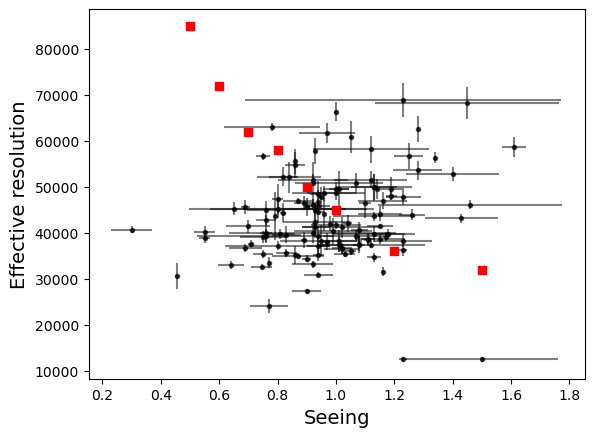

In [1355]:
plt.scatter(np.array(uves.seeing.values, dtype=float), uves.eff_res, s=5, color='k', alpha=0.5)

plt.scatter(uves_manual_slit, uves_manual_resolution, marker='s', color='r', zorder=9)

yerr = np.sqrt(300000*(uves.mg_fwhm_kms_rms.values/uves.mg_fwhm_kms.values)**-2. + 300000*(uves.tel_fwhm_kms_rms.values/uves.tel_fwhm_kms.values)**-2.)*uves.eff_res.values/300000
plt.errorbar(np.array(uves.seeing.values, dtype=float), uves.eff_res, xerr=np.array(uves.delta_seeing.values, dtype=float)/2., 
             yerr=yerr ,fmt='k.', alpha=0.5)  

# plt.xlim(0.25,1.8)
# plt.hlines(36000, 0.25, 2.25, color='g', ls='--')
plt.xlabel('Seeing', size=14)
plt.ylabel('Effective resolution', size=14)
plt.show()

In [1362]:
print('Median resolution: %d' %np.median(uves.eff_res.values))

Median resolution: 42043


In [8]:
# 4901776016635135488_3708493_124

In [32]:
#Define main function to normalise and measure RVs
def norm_RV(i, input_row):
    
#     if i != 0:
#         return
    
    ####################################################################################################################################################################################

    spec = ispec.read_spectrum('%s/%s' %(input_row.run, input_row.blue_file))
    spec['waveobs'] = spec['waveobs']/10.
    spec = spec[ispec.create_wavelength_filter(spec, wave_base=ini_wl_resample_blue, wave_top=end_wl_resample_blue)]
    spec['flux'] = spec['flux'] / np.median(spec['flux'])

    #Calculate RVs
    models, ccf = ispec.cross_correlate_with_template(spec, rv_template_blue, lower_velocity_limit=-500, upper_velocity_limit=500, velocity_step=0.1, fourier=False)
    rv_blue = np.round(models[0].mu(), 3) # km/s
    erv_blue = np.round(models[0].emu(), 3) # km/s
    spec = ispec.correct_velocity(spec, rv_blue)

    del models, ccf

    #Resample and normalise spec
    nknots = 50
    spec = ispec.resample_spectrum(spec, resample_wl_blue, method='linear', zero_edges=True)
    star_continuum_model = ispec.fit_continuum(spec, continuum_regions=continuum_regions_blue, nknots=nknots, degree=degree, 
                                           median_wave_range=median_wave_range, max_wave_range=max_wave_range, model=model, order=order, 
                                           automatic_strong_line_detection=True, strong_line_probability=0.55, use_errors_for_fitting=False)
    spec = ispec.normalize_spectrum(spec, star_continuum_model, consider_continuum_errors=False)

    del star_continuum_model

    #Save normalised spectrum
    ispec.write_spectrum(spec, 'norm_RV_corr/%s/blue_%s' %(input_row.run, input_row.blue_file))
    
    ####################################################################################################################################################################################
    
    spec = ispec.read_spectrum('%s/%s' %(input_row.run, input_row.red_file))
    spec['waveobs'] = spec['waveobs']/10.
    spec = spec[ispec.create_wavelength_filter(spec, wave_base=ini_wl_resample_red1, wave_top=end_wl_resample_red1)]
    spec['flux'] = spec['flux'] / np.median(spec['flux'])

    #Calculate RVs
    models, ccf = ispec.cross_correlate_with_template(spec, rv_template_red1, lower_velocity_limit=-500, upper_velocity_limit=500, velocity_step=0.1, fourier=False)
    rv_red1 = np.round(models[0].mu(), 3) # km/s
    erv_red1 = np.round(models[0].emu(), 3) # km/s
    spec = ispec.correct_velocity(spec, rv_red1)

    del models, ccf

    #Resample and normalise spec
    nknots = 50
    spec = ispec.resample_spectrum(spec, resample_wl_red1, method='linear', zero_edges=True)
    star_continuum_model = ispec.fit_continuum(spec, continuum_regions=continuum_regions_red1, nknots=nknots, degree=degree, 
                                           median_wave_range=median_wave_range, max_wave_range=max_wave_range, model=model, order=order, 
                                           automatic_strong_line_detection=True, strong_line_probability=0.55, use_errors_for_fitting=False)
    spec = ispec.normalize_spectrum(spec, star_continuum_model, consider_continuum_errors=False)

    del star_continuum_model

    #Save normalised spectrum
    ispec.write_spectrum(spec, 'norm_RV_corr/%s/red1_%s' %(input_row.run, input_row.red_file))

    ####################################################################################################################################################################################    

    spec = ispec.read_spectrum('%s/%s' %(input_row.run, input_row.red_file))
    spec['waveobs'] = spec['waveobs']/10.
    spec = spec[ispec.create_wavelength_filter(spec, wave_base=ini_wl_resample_red2, wave_top=end_wl_resample_red2)]
    spec['flux'] = spec['flux'] / np.median(spec['flux'])

    #Calculate RVs
    models, ccf = ispec.cross_correlate_with_template(spec, rv_template_red2, lower_velocity_limit=-500, upper_velocity_limit=500, velocity_step=0.1, fourier=False)
    rv_red2 = np.round(models[0].mu(), 3) # km/s
    erv_red2 = np.round(models[0].emu(), 3) # km/s
    spec = ispec.correct_velocity(spec, rv_red2)

    del models, ccf

    #Resample and normalise spec
    nknots = 50
    spec = ispec.resample_spectrum(spec, resample_wl_red2, method='linear', zero_edges=True)
    star_continuum_model = ispec.fit_continuum(spec, continuum_regions=continuum_regions_red2, nknots=nknots, degree=degree, 
                                           median_wave_range=median_wave_range, max_wave_range=max_wave_range, model=model, order=order, 
                                           automatic_strong_line_detection=True, strong_line_probability=0.55, use_errors_for_fitting=False)
    spec = ispec.normalize_spectrum(spec, star_continuum_model, consider_continuum_errors=False)

    del star_continuum_model

    #Save normalised spectrum
    ispec.write_spectrum(spec, 'norm_RV_corr/%s/red2_%s' %(input_row.run, input_row.red_file))

   ################################################################################################################################################################################

    return rv_blue, erv_blue, rv_red1, erv_red1, rv_red2, erv_red2

In [53]:
uves = pd.read_csv('uves_p111_p112_header_rv.csv')

In [ ]:
4901776016635135488_3708493_124

In [54]:
uves.query("spec_id == '4901776016635135488_3708493_124'").iloc[0]

source_id                    4901776016635135488
spec_id          4901776016635135488_3708493_124
run                                 112.25XW.001
blue_file       ADP.2024-02-23T09:21:23.194.fits
red_file        ADP.2024-02-23T09:21:23.190.fits
airmass                                    1.304
seeing                                      1.49
mjd                                 60200.183052
OB                                       3708493
exptime                                3599.9995
ra                                      8.069582
dec                                    -62.12659
blue_snr                                 39.6755
red_snr                                 103.3339
nom_res_blue                             36840.0
nom_res_red                              34540.0
barycor                                -6.306793
rv_blue                                   466.97
erv_blue                                   0.047
rv_red1                                   467.47
erv_red1            

In [56]:
# norm_RV(124, uves.query("spec_id == '4901776016635135488_3708493_124'").iloc[0])

In [ ]:
466.97,0.047,467.47,0.038,467.35,0.06